# **MACHINE LEARNING**
---
### Thông tin nhóm:
- STT nhóm: 10

|MSSV|Họ và tên|
|:---|:--------|
|18120066|Bùi Đoàn Hữu Nhân|
|18120085|Nguyễn Tấn Thìn|
|18120090|Phạm Nguyên Minh Thy|
|18120097|Đinh Hữu Phúc Trung|
|18120649|Nguyễn Phạm Phúc Việt|


---

# **LAB01 - REGRESSION**

### Yêu cầu:
- Đọc và phân tích đặc trưng trong 2 tập tin "train.csv" và "test.csv". Trình bày các thông tin hữu ích tác động đến chi phí y tế cá nhân.
- Cài đặt các thuật toán máy học đã được học để dự đoán chi phí y tế cá nhân.
- Báo cáo kết quả. Từ đó nhận xét các tác nhân ảnh hưởng tới chi phí y tế cá nhân.

---

## **Import**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import plotly.express as px
import io
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder, FunctionTransformer, StandardScaler

## **Khám phá dữ liệu**

In [2]:
url = 'https://raw.githubusercontent.com/dinhhuuphuctrung/lab01-Regression/main/train.csv'
train_df = pd.read_csv(url)
train_df.head()

,age,sex,bmi,children,smoker,region,charges
0,24,male,23.655,0,no,northwest,2352.96845
1,28,female,26.510,2,no,southeast,4340.44090
2,51,male,39.700,1,no,southwest,9391.34600
3,47,male,36.080,1,yes,southeast,42211.13820
4,46,female,28.900,2,no,southwest,8823.27900


In [3]:
url = 'https://raw.githubusercontent.com/dinhhuuphuctrung/lab01-Regression/main/test.csv'
test_df = pd.read_csv(url)
test_df.head()

,age,sex,bmi,children,smoker,region,charges
0,45,female,25.175,2,no,northeast,9095.06825
1,36,female,30.020,0,no,northwest,5272.17580
2,64,female,26.885,0,yes,northwest,29330.98315
3,46,male,25.745,3,no,northwest,9301.89355
4,19,male,31.920,0,yes,northwest,33750.29180


In [4]:
train_df.shape

(1003, 7)

In [5]:
test_df.shape

(335, 7)

In [6]:
train_df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [7]:
X_train_raw = train_df.drop("charges", axis=1)
X_test_raw = test_df.drop("charges", axis=1)
y_train = train_df["charges"]
y_test = test_df["charges"]

In [8]:
X_train_raw.dtypes[X_train_raw.dtypes != object]

age           int64
bmi         float64
children      int64
dtype: object

In [9]:
num_cols = ['age', 'bmi', 'children']
df = X_train_raw[num_cols]
def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)
def lower_quartile(df):
    return df.quantile(0.25).round(1)
def median(df):
    return df.quantile(0.5).round(1)
def upper_quartile(df):
    return df.quantile(0.75).round(1)
df.agg([missing_ratio, 'min', lower_quartile, median, upper_quartile, 'max'])

,age,bmi,children
missing_ratio,0.0,0.00,0.0
min,18.0,15.96,0.0
lower_quartile,27.0,26.20,0.0
median,39.0,30.20,1.0
upper_quartile,51.0,34.40,2.0
max,64.0,53.13,5.0


In [10]:
pd.set_option('display.max_colwidth', 200)
cat_cols = ['sex', 'smoker', 'region']
df = train_df[cat_cols]
def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)
def num_values(df):
    return df.nunique()
def value_ratios(c):
    return dict((c.value_counts(normalize=True) * 100).round(1))
df.agg([missing_ratio, num_values, value_ratios])

,sex,smoker,region
missing_ratio,0,0,0
num_values,2,2,4
value_ratios,"{'male': 50.4, 'female': 49.6}","{'no': 79.5, 'yes': 20.5}","{'southeast': 25.8, 'northeast': 25.0, 'southwest': 24.6, 'northwest': 24.5}"


##**Phân tích các đặc trưng**

Trình bày các thông tin hữu ích (insights) tác động đến chi phí y tế cá nhân. 

#### Age

In [11]:
bins = [17, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]
groups = train_df.groupby([pd.cut(train_df.age, bins)])['charges'].agg(['mean'])
fig = px.bar(groups, x=groups.index.astype(str), y='mean', labels={'mean': 'Charges per capita', 'x': 'Age'},
             title='Biểu đồ chi phí y tế cá nhân trung bình nhóm theo tuổi')
fig.show()

- Nhận xét: Trong các nhóm tuổi từ 18 đến 65, chi phí y tế cá nhân trung bình có tỉ lệ thuận với nhóm tuổi, nghĩa là nhóm tuổi càng cao thì chi phí càng lớn, từ đó cho thấy được tuổi (age) có tác động, ảnh hưởng tương đối đến chi phí y tế cá nhân.

#### Sex

In [12]:
df_temp = train_df.groupby(train_df['sex'])['charges'].agg(['mean']).sort_values(by=['mean'], ascending=False)
#print(df_temp)
fig = px.bar(df_temp, x=df_temp.index, y='mean', labels={'mean': 'Charges per capita', 'x': 'Sex'}, 
             title='Biểu đồ chi phí y tế cá nhân trung bình nhóm theo giới tính')
fig.show()

- Nhận xét: Chi phí y tế bình quân trên đầu người của nam và nữ có chênh lệch không đáng kể, từ đó cho thấy giới tính (age) có ảnh hướng rất yếu tới chi phí y tế cá nhân.

#### BMI

In [13]:
# số người có BMI trên 50 quá ít, nên ta chỉ xét đến 50 cho việc phân tích được chính xác hơn
bins = [15, 20, 25, 30, 35, 40, 45, 50]
groups = train_df.groupby([pd.cut(train_df.bmi, bins)])['charges'].agg(['mean'])
fig = px.bar(groups, x=groups.index.astype(str), y='mean', labels={'mean': 'Charges per capita', 'x': 'BMI'},
             title='Biểu đồ chi phí y tế cá nhân trung bình nhóm theo BMI')
fig.show()

- Nhận xét: Trong các nhóm BMI từ 15 đến 65, chi phí y tế cá nhân trung bình có tỉ lệ thuận với BMI, nghĩa là nhóm BMI càng cao thì chi phí càng lớn, từ đó cho thấy được chỉ số BMI có ảnh hưởng tương đối tới chi phí y tế cá nhân.

#### Children

In [14]:
df_temp = train_df.groupby(train_df['children'])['charges'].agg(['mean']).sort_values(by=['mean'], ascending=False)
#print(df_temp)
fig = px.bar(df_temp, x=df_temp.index, y='mean', labels={'mean': 'Charges per capita', 'x': 'Children'},
             title='Biểu đồ chi phí y tế cá nhân trung bình nhóm theo số trẻ con/người phụ thuộc')
fig.show()

- Nhận xét: Qua biểu đồ, phần nào cho ta thấy được việc có nhiều hay ít trẻ con/người phụ thuộc không ảnh hưởng đến chi phí y tế cá nhân của người đó quá nhiều.

#### Smoker

In [15]:
df_temp = train_df.groupby(train_df['smoker'])['charges'].agg(['mean']).sort_values(by=['mean'], ascending=False)
#print(df_temp)
fig = px.bar(df_temp, x=df_temp.index, y='mean', labels={'mean': 'Charges per capita', 'x': 'Smoke'},
              title='Biểu đồ chi phí y tế cá nhân trung bình nhóm theo tình trạng hút thuốc')
fig.show()

- Nhân xét: Chi phí y tế cá nhân trung bình của người có hút thuốc lớn hơn nhiều lần so với người không hút thuốc, từ đó cho thấy được tình trạng hút thuốc (smoker) có ảnh hướng mạnh đến việc dự đoán chi phí y tế cá nhân.

#### Region

In [16]:
df_temp = train_df.groupby(train_df['region'])['charges'].agg(['mean']).sort_values(by=['mean'], ascending=False)
#print(df_temp)
fig = px.bar(df_temp, x=df_temp.index, y='mean', labels={'mean': 'Charges per capita', 'x': 'Region'},
              title='Biểu đồ chi phí y tế cá nhân trung bình nhóm theo khu vực')
fig.show()

- **Nhận xét**: Chi phí y tế cá nhân trung bình của mỗi khu vực có chênh lệch không đáng kể, từ đó phần nào cho thấy được khu vực (region) có ảnh hướng khá yếu tới chi phí y tế cá nhân.

## **Tiền xử lý dữ liệu**

- Ta thấy có 3 cột không thuộc kiểu dữ liệu số là ['sex', 'smoker', 'region'], nên ta cần tiền xử lí để có thể huấn luyện mô hình. Có hai cách để tiền xử lí  3 cột trên, cách một là loại bỏ hoàn toàn, hai là đưa về dạng dữ liệu số.
- Nhìn vào 3 cột dữ liệu trên, ta thấy cột 'sex' có hai dữ liệu là **male** và **female** nên ta sẽ đưa về male thành 1 và female thành 0. Tương tự cột 'smoker' cũng có hai dữ liệu là **yes** và **no** nên ta chọn yes là 1 và no là 0. Cột 'region' là những địa điểm cụ thể nên ta sẽ cho mỗi khu vực lần lượt là 0 trở đi



In [17]:
def MulticolLabelEncode(X):

  numeric = X.select_dtypes(np.number)
  non_numeric = X.select_dtypes(object)
  non_numeric_encoded = non_numeric.apply(LabelEncoder().fit_transform)
  
  return numeric.join(non_numeric_encoded)

X_train_encoded = MulticolLabelEncode(X_train_raw)
X_train_encoded.head()

,age,bmi,children,sex,smoker,region
0,24,23.655,0,1,0,1
1,28,26.510,2,0,0,2
2,51,39.700,1,1,0,3
3,47,36.080,1,1,1,2
4,46,28.900,2,0,0,3


Quan sát mức độ tương quan tuyến tính giữa các cột trong X_train_encoded và y_train:

In [18]:
X_train_encoded.corrwith(y_train, method = 'pearson')

age         0.293434
bmi         0.195828
children    0.079823
sex         0.043353
smoker      0.781981
region     -0.004034
dtype: float64

Dựa vào việc phân tích ở trên và các chỉ số tương quan này, ta sẽ tiến hành tiền xử lí loại bỏ các cột (đặc trưng) có ảnh hướng yếu đến chi phí y tế cá nhân (có mức độ tương quan thấp) để việc dự đoán chính xác hơn, cụ thể ở đây là 3 cột children, sex và region, với chỉ số tương quan dưới 0.1. Viết hàm loại bỏ các cột đó:



In [19]:
def DropLowCorr(X):
  low_corr = ['region','sex','children']
  return X.drop(columns = low_corr)

Tạo pipeline tiền xử lý:

In [20]:
MulticolLabelEncoder = FunctionTransformer(MulticolLabelEncode)
LowCorrDropper = FunctionTransformer(DropLowCorr)
preprocess_pipeline = make_pipeline(MulticolLabelEncoder, 
                                    LowCorrDropper,
                                    StandardScaler())
X_train = preprocess_pipeline.fit_transform(X_train_raw)
X_test = preprocess_pipeline.transform(X_test_raw)

## **Cài đặt các thuật toán máy học**

### Linear Regression:

In [21]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print("Training set score: {:.4f}".format(lr.score(X_train, y_train)))
print("Test set score:  {:.4f}".format(lr.score(X_test, y_test)))

Training set score: 0.7423
Test set score:  0.7623


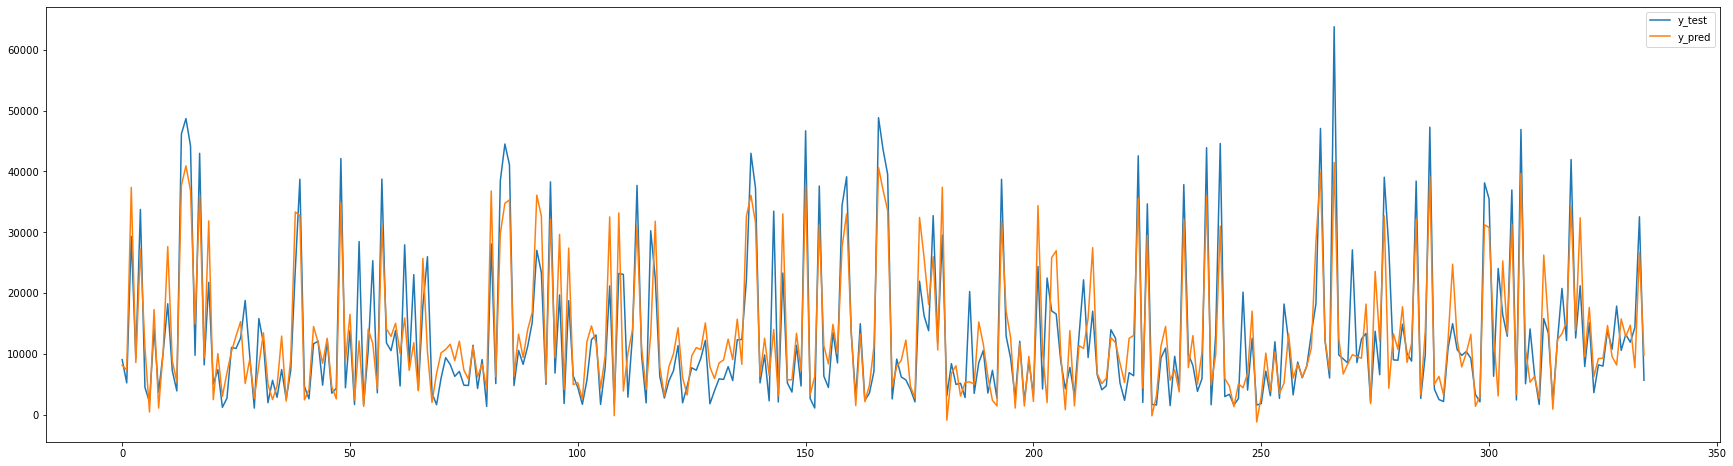

In [22]:
plt.figure(figsize=(30, 8))
plt.plot(y_test, label='y_test')
plt.plot([lr.predict([i]) for i in X_test], label='y_pred')
plt.legend()
plt.show()

### Ridge Regression:

In [23]:
rr = Ridge()
rr.fit(X_train, y_train)
print("Training set score: {:.4f}".format(rr.score(X_train, y_train)))
print("Test set score:  {:.4f}".format(rr.score(X_test, y_test)))

Training set score: 0.7423
Test set score:  0.7623


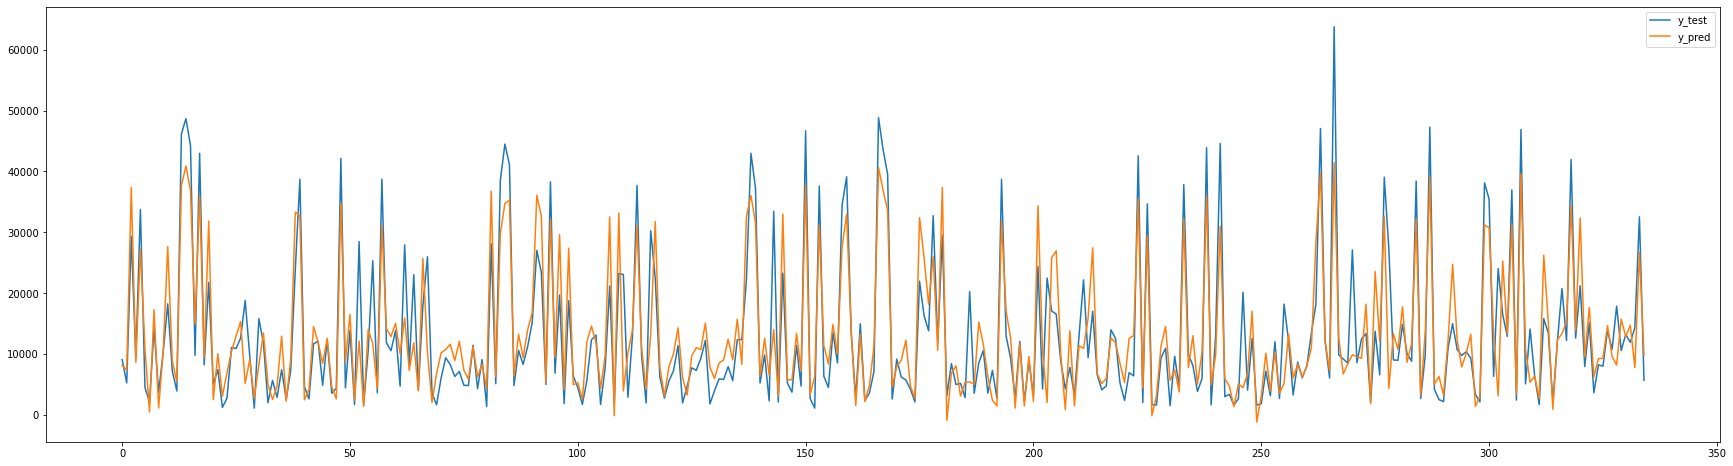

In [24]:
plt.figure(figsize=(30, 8))
plt.plot(y_test, label='y_test')
plt.plot([rr.predict([i]) for i in X_test], label='y_pred')
plt.legend()
plt.show()

### K-Neighbors Regression


In [25]:
from sklearn.neighbors import KNeighborsRegressor
knr = KNeighborsRegressor(n_neighbors = 10)
knr.fit(X_train, y_train)
print("Training set score: {:.4f}".format(knr.score(X_train, y_train)))
print("Test set score:  {:.4f}".format(knr.score(X_test, y_test)))

Training set score: 0.8643
Test set score:  0.8598


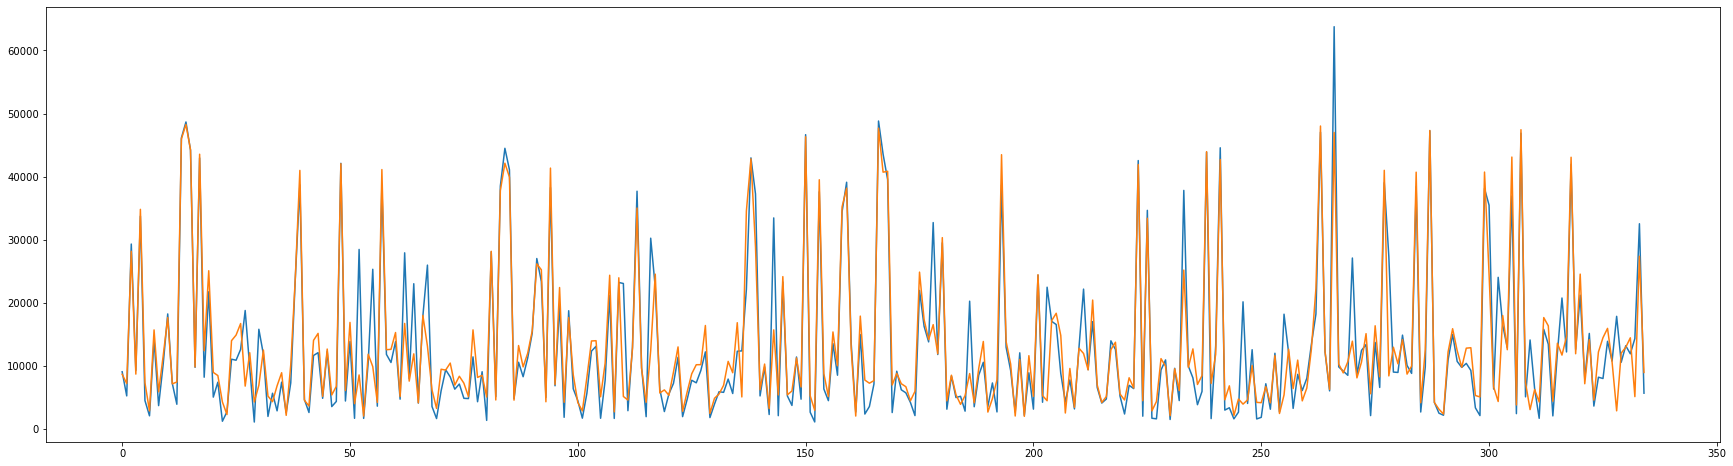

In [26]:
plt.figure(figsize=(30, 8))
plt.plot(y_test)
plt.plot([knr.predict([i]) for i in X_test])

### Polynomial Regression

In [27]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg=PolynomialFeatures(degree=3)
X_poly=poly_reg.fit_transform(X_train)

lin_reg2=LinearRegression()
lin_reg2.fit(X_poly,y_train)

print("Training set score: {:.4f}".format(lin_reg2.score(poly_reg.fit_transform(X_train),y_train)))
print("Test set score:  {:.4f}".format(lin_reg2.score(poly_reg.fit_transform(X_test),y_test)))

Training set score: 0.8377
Test set score:  0.8512


In [28]:
poly_predict = lin_reg2.predict(poly_reg.fit_transform(X_test))
#poly_predict

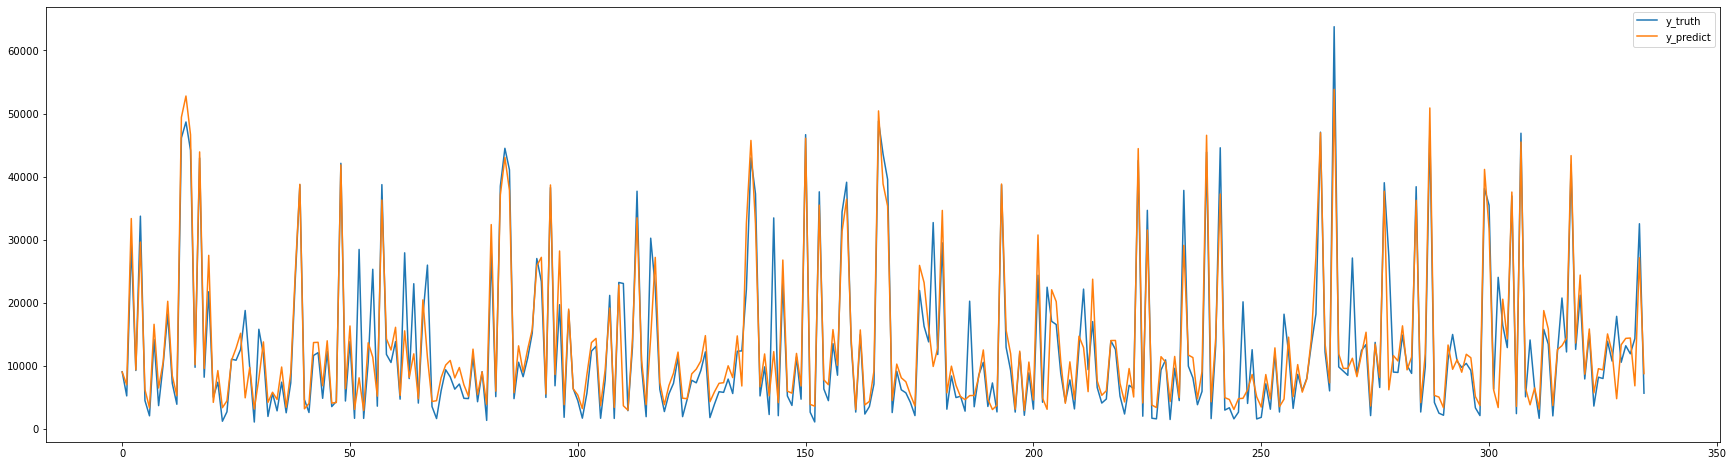

In [29]:
plt.figure(figsize=(30, 8))
plt.plot(y_test, label = 'y_truth')
plt.plot(poly_predict, label = 'y_predict')
plt.legend()

### Kernel Regression
Gồm:

- Non-parametric Kernel Regression
- Parametric Kernel Regression 

#### Non-parametric Kernel Regression

In [30]:
from scipy.stats import multivariate_normal
from sklearn.metrics import r2_score

In [31]:
class GKR:
    def __init__(self, x, y):
        self.x = np.array(x)
        self.y = np.array(y)
    def gaussian_kernel(self, z):
        return np.exp(-0.5*(z)**2)
    def predict(self, X):
        kernels = np.array([self.gaussian_kernel((np.linalg.norm(X-xi))) for xi in self.x])
        alpha = np.array([(kernel/np.sum(kernels)) for kernel in kernels])
        return np.dot(alpha.T, self.y)  

In [32]:
gkr = GKR(X_train,y_train)
ypred_train = np.array([gkr.predict(i) for i in X_train])
ypred_test = np.array([gkr.predict(i) for i in X_test])
print("Train set score:  {:.4f}".format(r2_score(y_train,ypred_train)))
print("Test set score:  {:.4f}".format(r2_score(y_test,ypred_test)))

Train set score:  0.7695
Test set score:  0.7903


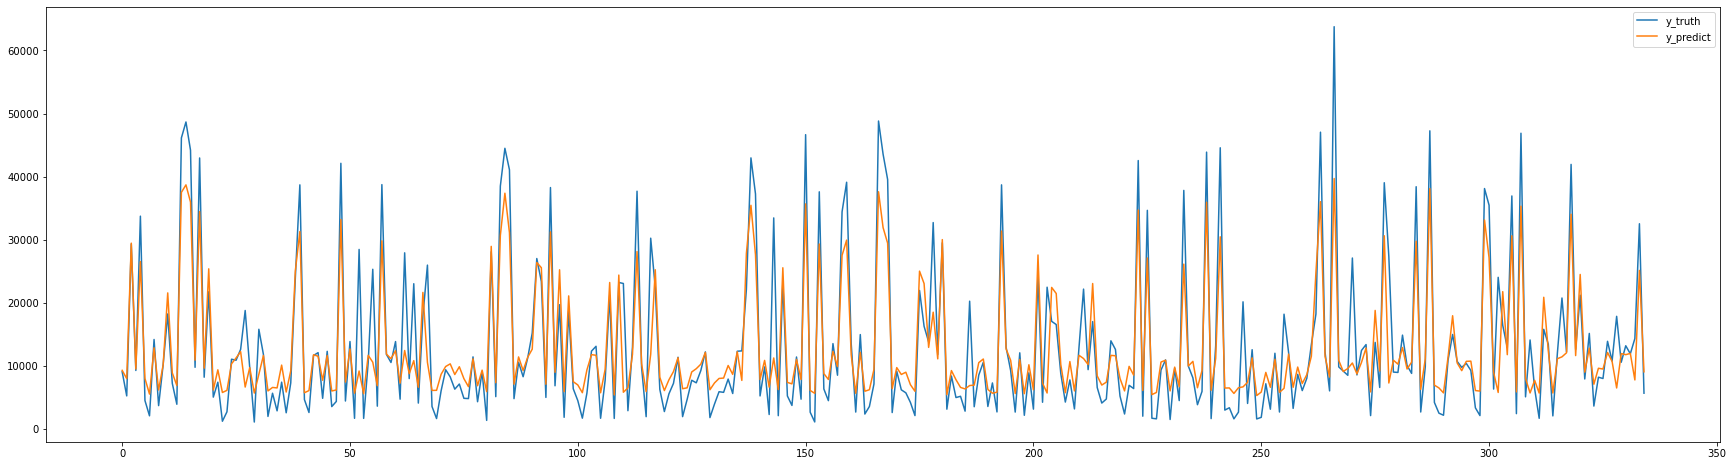

In [33]:
plt.figure(figsize=(30, 8))
plt.plot(y_test, label = 'y_truth')
plt.plot(ypred_test, label = 'y_predict')
plt.legend()

#### Parametric Kernel Regression

In [34]:
class GKR_w:
    def __init__(self, x, y, w):
        self.x = np.array(x)
        self.y = np.array(y)
        self.w = w
    def gaussian_kernel(self, z):
        return np.exp(-0.5*(z*self.w)**2) #have w
    def predict(self, X):
        kernels = np.array([self.gaussian_kernel((np.linalg.norm(X-xi))) for xi in self.x])
        alpha = np.array([(kernel/np.sum(kernels)) for kernel in kernels])
        return np.dot(alpha.T, self.y)  

In [35]:
gkr_w = GKR_w(X_train,y_train,6)
ypred_train = np.array([gkr_w.predict(i) for i in X_train])
ypred_test = np.array([gkr_w.predict(i) for i in X_test])
print("Train set score:  {:.4f}".format(r2_score(y_train,ypred_train)))
print("Test set score:  {:.4f}".format(r2_score(y_test,ypred_test)))

Train set score:  0.8780
Test set score:  0.8609


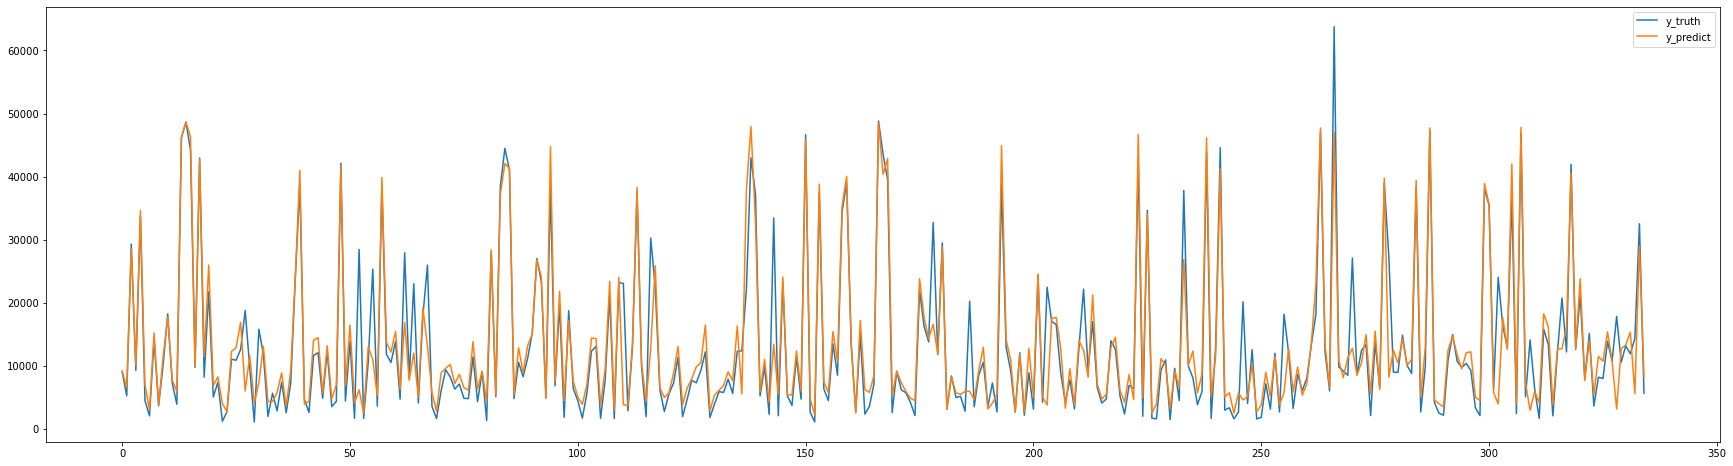

In [36]:
plt.figure(figsize=(30, 8))
plt.plot(y_test, label = 'y_truth')
plt.plot(ypred_test, label = 'y_predict')
plt.legend()